# Inferential statistics II - Bootstrapping

## Introduction

In the previous exercises you performed frequentist calculations to perform inference from a sample of data. Such inference relies on theory largely developed from the 19th Century onwards that is subject to certain assumptions or theoretical limits. These are fine if those assumptions hold in your case, and what you want to do has a known theoretical distribution, for example the mean of a sampling distribution that we looked at.

In these exercises we are once again going to load in the medical charge data but this time we are going to make inferences about the population using bootstrapping, that is simulating repeated re-runs of an experiment. If frequentism is about using assumptions and theoretical results to calculate what we expect to happen were an experiment to be run again and again and again, then bootstrapping is about using computing power to essentially re-run the sample draw again and again and again to see what actually happens.

## Prerequisites

Whilst these exercises do not strictly depend on these concepts, before working through them, you should have completed the preceding assignment and have a good understanding of such frequentist concepts as
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate confidence intervals and p-values
* how those confidence intervals and p-values allow you to perform hypothesis (or A/B) tests

To complete these exercises, you should have covered the material on how to calculate bootstrap replicates of summary statistics. Having an appreciation of what confidence intervals and p-values are will be helpful.

In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt

## Medical charge data set

In [2]:
med_charges = pd.read_csv('data/insurance2.csv')

In [3]:
med_charges.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In the previous assignment, you used the frequentist approach to estimate the lower limit for the 95% confidence interval on the mean hospital charge. This approach relies on statistical theory that has been developed over the years and is also limited to statistics for which theoretical results on the sampling distribution exist. These results are remarkably useful and applicable much of the time and under a surprisingly wide range of conditions.

Having calculated the 95% lower confidence interval using frequentist theory in the previous exercise, you would like to verify your calculations and check you get consistent results without making the assumptions required before. After all, the distribution of charges really was very non-normal.

__Q:__ Use bootstrap sampling to estimate the same 95% confidence interval lower limit as before.

__A:__

In [95]:
np.random.seed(47)
N_rep = 10000

# Define function to randomly select a sample from a dataset (of the same size)
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

# Define function to get size number of bootstrap replicates using an input sample and replicate function
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

# Draw bootstrap replicates of mean
bs_replicates = draw_bs_reps(med_charges.charges, np.mean, size=N_rep)

# Compute the one-tailed  95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates, [5])
print('Lower Confidence Interval: ', conf_int)

Lower Confidence Interval:  [12724.4679217]


If you performed 10000 replicates immediately after setting the random seed to 47, you should get the value 12724 here, which compares very well with the value 12725 obtained using the _t_-distribution confidence interval previously. It is a most pleasant result to see the predictions of classical frequentist theory match with results that are now possible through the number-crunching ability of computers.

Remember in the previous exercise set, we saw there are two ways of performing a _t_-test from a sample, depending on whether we can assume the groups have equal variance or not. We can actually easily test this using the bootstrap!

__Q:__ Calculate the 95% confidence interval for the difference between the standard deviations of insurance and non-insurance claim charges (insured - non-insured). Calculate the differences over 10000 replicates. Plot the histogram of values and mark the locations of the percentiles. State the null and alternative hypothesis and comment on whether you would retain or reject the null hypothesis in this case and why.

__A:__

95% Confidence Interval:  [6682.39976943 8497.78638056]


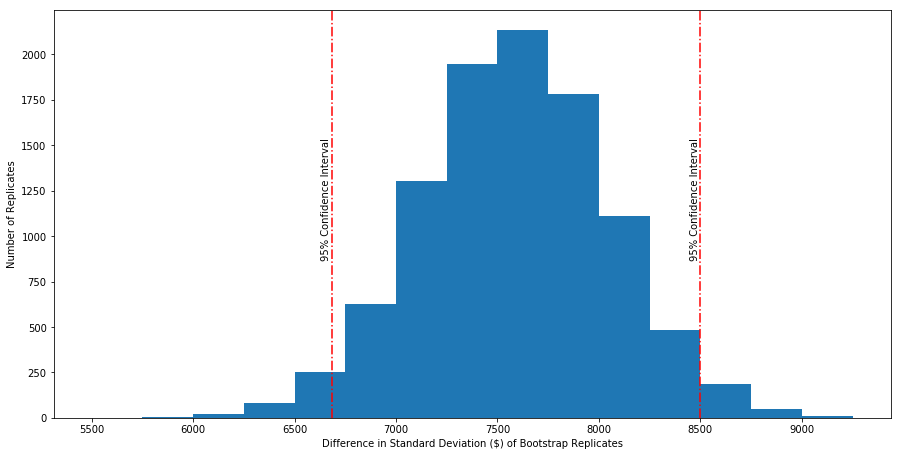

In [78]:
# Draw bootstrap replicates of the standard deviation of the insurance / no insurance charges
bs_replicates_ins = draw_bs_reps(charges_ins.charges, np.std, size=10000)
bs_replicates_no_ins = draw_bs_reps(charges_no_ins.charges, np.std, size=10000)

# Calculate the differeence in standard deviation between each bootstrap standard deviation 
bs_replicates_diff = bs_replicates_ins - bs_replicates_no_ins

# Calculate the two-tailed 95% confidence interval 
conf_int = np.percentile(bs_replicates_diff, [2.5, 97.5])
print('95% Confidence Interval: ', conf_int)

# Set the bins for the histogram
bins = range(5500,9500,250)

# Plot the figure
_ = plt.figure(figsize=(15,7.5))
_ = plt.hist(bs_replicates_diff, bins=bins)

_ = plt.xlabel('Difference in Standard Deviation ($) of Bootstrap Replicates')
_ = plt.ylabel('Number of Replicates')

_ = plt.axvline(conf_int[0], color='r', linestyle='-.')
_ = plt.axvline(conf_int[1], color='r', linestyle='-.')
_ = plt.text(conf_int[0] - 50,1500,'95% Confidence Interval',rotation=90)
_ = plt.text(conf_int[1] - 50,1500,'95% Confidence Interval',rotation=90)

- Null Hypothesis: Charges with no insurance claim and charges with insurance claims have the same standard deviations.
- Alternative Hypothesis: Charges with no insurance claim and charges with insurance claims have different standard deviations.


- Result: The null hypothesis is rejected as as the 95% confidence intervals does not contain '0' difference in standard deviations between the two samples. 

Alternatively, the following test using permutations can be performed to arrive at the same conclusion:

In [11]:
# Create separate dataframes for charges with no insurance and charges with insurance
charges_ins = med_charges[med_charges.insuranceclaim == 1]
charges_no_ins = med_charges[med_charges.insuranceclaim == 0]

In [34]:
def diff_of_stds(data_1, data_2):
    """Difference in standard deviations of two arrays."""

    # The difference of standard deviations of data_1, data_2: diff
    diff = np.std(data_1) - np.std(data_2)

    return diff

In [16]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [14]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

In [97]:
# Compute difference of standard deviations between the two samples
empirical_diff_stds = diff_of_stds(charges_ins.charges, charges_no_ins.charges)

# Draw 10,000 permutation replicates
perm_replicates = draw_perm_reps(charges_ins.charges, charges_no_ins.charges,
                                 diff_of_stds, size=10000)

# Calculate the two-tailed 95% confidence interval 
conf_int = np.percentile(perm_replicates, [2.5, 97.5])
print('Confidence Interval: ', conf_int)

Confidence Interval:  [-1224.80955756  1248.52022784]


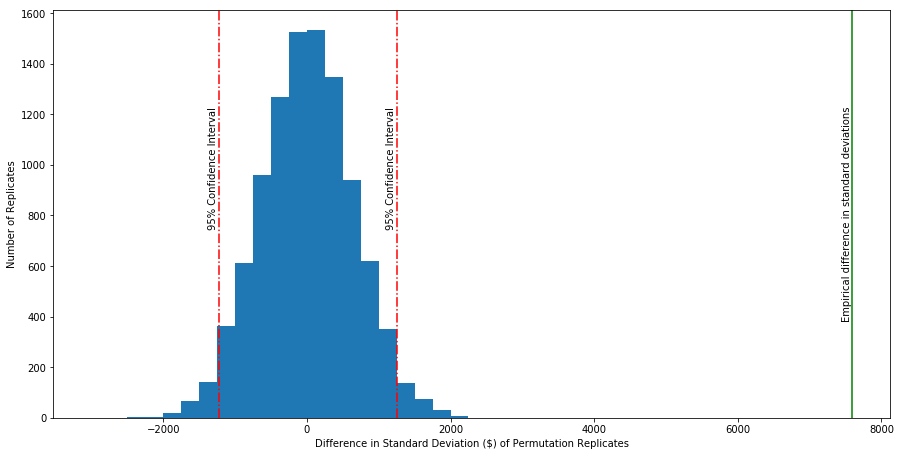

In [98]:
# Set bins for histogram
bins = range(-3000,3000,250)

# Plot figure
_ = plt.figure(figsize=(15,7.5))
_ = plt.hist(perm_replicates, bins=bins)

_ = plt.axvline(conf_int[0], color='r', linestyle='-.')
_ = plt.axvline(conf_int[1], color='r', linestyle='-.')

_ = plt.axvline(empirical_diff_stds, color='g', linestyle='solid')

_ = plt.xlabel('Difference in Standard Deviation ($) of Permutation Replicates')
_ = plt.ylabel('Number of Replicates')
_ = plt.text(empirical_diff_stds - 150,1200,'Empirical difference in standard deviations',rotation=90)
_ = plt.text(conf_int[0] - 150,1200,'95% Confidence Interval',rotation=90)
_ = plt.text(conf_int[1] - 150,1200,'95% Confidence Interval',rotation=90)

plt.show()

- Null Hypothesis: Charges with no insurance claim and charges with insurance claims have the same standard deviations.
- Alternative Hypothesis: Charges with no insurance claim and charges with insurance claims have different standard deviations.


- Result: The null hypothesis is rejected as the observed difference in standard deviation between the two groups is extremely greater than the 95% confidence interval of oberved differences when treating the samples as the same. 

## Confidence interval and p-value

The confidence interval above is often a useful quantity to estimate. If we wish to limit our expected probability of making a Type II error (where we wrongly reject the null hypothesis, and it is, instead, true) to $\alpha$, the associated confidence interval is our estimate of the interval within which we expect the true population value to be found $100\times(1 - \alpha)$% of the time we do this test. In the above we performed bootstrap replicates to estimate the interval and reject the null hypothesis if this interval did not contain zero. You will sometimes see such an interval reported in the output of statistical functions.

The partner of the confidence interval is the p-value. The p-value and the confidence interval are linked through our choice of $\alpha$. The p-value tells us how likely it is, under the null hypothesis, to get an outcome at least as extreme as what was observed. If this fails to reach the level of our _pre-specified_ $\alpha$, we decide the null hypothesis is sufficiently unlikely to be true and thus reject it. To calculate this p-value via the bootstrap, we have to put ourselves in a position where we are simulating the null hypothesis being true and then calculate the fraction of times we observe a result at least as extreme as that actually observed.

Remember how, previously, you used the _t_-test to calculate the p-value for the observed difference between the means of insured and non-insured medical cases. We're now going to repeat this but using the bootstrap.

__Q:__ Perform a bootstrapped hypothesis test at the 5% significance level ($\alpha = 0.05$) to calculate the p-value of the observed difference between insurance and non-insurance charges, state your null and alternative hypotheses and whether you retain or reject the null hypothesis for the given significance level.

__A:__

In [87]:
# Create separate dataframes for charges with no insurance and charges with insurance
charges_ins = med_charges[med_charges.insuranceclaim == 1]
charges_no_ins = med_charges[med_charges.insuranceclaim == 0]

# Compute mean of all charges
mean_charge = np.mean(med_charges.charges)

# Compute difference of means between the two samples:
empirical_diff_means = np.mean(charges_ins.charges) - np.mean(charges_no_ins.charges)

# Generate shifted arrays
ins_shifted = charges_ins.charges - np.mean(charges_ins.charges) + mean_charge
no_ins_shifted = charges_no_ins.charges - np.mean(charges_no_ins.charges) + mean_charge 

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(ins_shifted, np.mean, size=10000)
bs_replicates_b = draw_bs_reps(no_ins_shifted, np.mean, size=10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_a - bs_replicates_b

# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)

# Print the result
print('p-value =', p)

p-value = 0.0


- Null Hypothesis: Charges with no insurance claim and charges with insurance claims have the same mean.
- Alternative Hypothesis: Charges with no insurance claim and charges with insurance claims have different means.


- Result: The null hypothesis is rejected as the observed empirical difference in the means was not observed a single time in the bootstrap replicates.

__Q:__ To put the above result in perspective, plot the histogram of your bootstrapped differences along with lines marking the locations of the observed difference. (Why would we plot more than one line, given that we only have one observed difference?)

__A:__

Confidence Interval:  [-1111.42672165  1149.78769366]


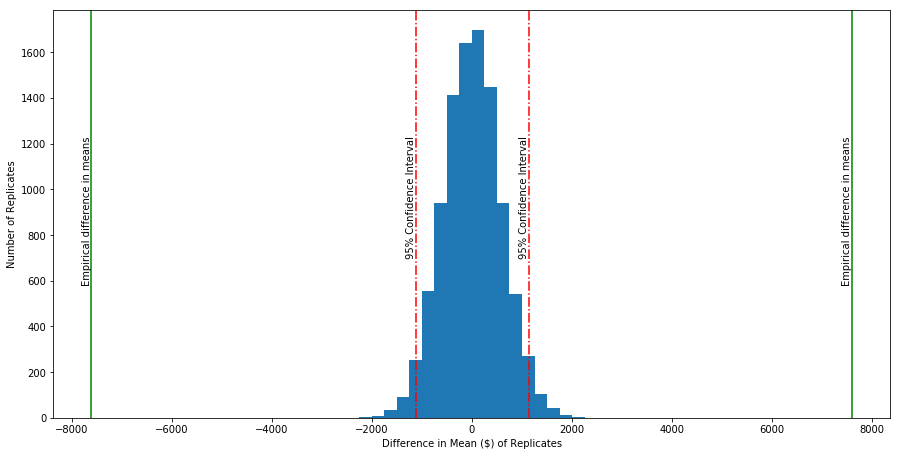

In [91]:
# Set bins for histogram
bins = range(-3000,3000,250)

# Calculate the 95% confidence interval 
conf_int = np.percentile(bs_replicates, [2.5, 97.5])
print('Confidence Interval: ', conf_int)

# Compute difference of means between the two samples:
empirical_diff_means = np.mean(charges_ins.charges) - np.mean(charges_no_ins.charges)

# Plot figure
_ = plt.figure(figsize=(15,7.5))
_ = plt.hist(bs_replicates, bins=bins)

_ = plt.axvline(conf_int[0], color='r', linestyle='-.')
_ = plt.axvline(conf_int[1], color='r', linestyle='-.')

_ = plt.axvline(empirical_diff_means, color='g', linestyle='solid')
_ = plt.axvline(-empirical_diff_means, color='g', linestyle='solid')

_ = plt.xlabel('Difference in Mean ($) of Replicates')
_ = plt.ylabel('Number of Replicates')
_ = plt.text(empirical_diff_stds - 200,1200,'Empirical difference in means',rotation=90)
_ = plt.text(-empirical_diff_stds - 200,1200,'Empirical difference in means',rotation=90)
_ = plt.text(conf_int[0] - 200,1200,'95% Confidence Interval',rotation=90)
_ = plt.text(conf_int[1] - 200,1200,'95% Confidence Interval',rotation=90)

plt.show()

- As shown on the above graph, the positive/negative observed empirical differences in the means are far from the distribution of differences of the means of bootstrap replicates. 

__Q:__ Compare your p-value above with that obtained using the _t_-test function in the previous assignment. Do you think you would want to try to perform enough bootstrap replicates to observe a random difference as large as that we did observe?

__A:__

The probability of observing a random difference as large as that observed empirically is extremely small when the two samples are assumed to have the same mean. It would very, very large amount of repetitions to happen. 

__Q:__ Remember the two variants of the _t_-test we performed in the previous assignment. Which one would you use now?

__A:__

- Above, we showed that the standard deviations (and therefore variances) of the two (insured and not insured) samples are different to > 95% certainty. We should perform the test that accounts for the variances being different: 

In [93]:
import scipy.stats as stats

t_sci = stats.ttest_ind(charges_ins.charges, charges_no_ins.charges, equal_var=0)
t_sci

Ttest_indResult(statistic=13.298031957975649, pvalue=1.1105103216309125e-37)

__Q:__ If, instead of being asked whether the means of two groups were different, you were working with an ad-recommender team who wanted to release a new recommendation algorithm, and you were looking at click-through rate both for the current algorithm (call it A) and from trials of their new algorithm (call it B), would you perform a two-sided test as above? What would be your null and alternative hypotheses and what would be the real world consequence of rejecting the null hypothesis?

__A:__

- In the scenario described above, I would perform a one-sided test as it would be most pertinent to know if algorithm B improves (i.e. increases) the click-through rate when compared to algorithm A. 
- Null hypothesis: The click-through rates of algorithm A and B are equal.
  Alternative hypthothesis: The click-through rate of algorithm B is greater than that of algorithm A. 
- The real-world consequence of rejecting the null hypothesis would be that you have claimed with some degree of certainty that the new algorithm is an improvement on the ad-recommender and thus it should be implemented. It's likely the team would want to proceed with the new algorithm, and thus any problems with the click-through rate once implemented may cast doubt on your assessment.

# Learning outcomes

You've previously applied frequentist methods to calculate confidence intervals, p-values, and perform hypothesis tests. Frequentist methods use theoretical results to calculate what we expect would happen if experiments were to be run again and again and again. Now you've seen how you can do the same things using the bootstrap approach, which does not rely on such theory, and attendant assumptions, but instead literally does run experiments again and again and again.

In these exercises, you have
* calculated the same confidence interval lower limit as you did previously
* tested the assumption that the variances of the two groups (insured vs. non-insured) were equal - something a bit harder to do using the frequentist method because of the nature of the sampling distribution for variance
* calculated the p-value for the difference between the means of the two groups and compared with the result obtained using the previous frequentist approach

You are now well equipped to apply the bootstrap approach to a wide variety of problems. Just think about what conditions you wish to recreate in your simulated reruns.